In [ ]:
# --- Imports ---
import os, numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
from astropy.modeling import models, fitting
import warnings
warnings.filterwarnings("ignore")

# --- Config: point to ONE galaxy folder ---
BASE_DIR   = r"Galaxies Spectrography and Analysis 2"
GALAXY_DIR = os.path.join(BASE_DIR, "data", "galaxy_2")  #Changing of the files of different galxies
SPEC_PATH  = os.path.join(GALAXY_DIR, "spectrum.fits")
IMG_PATHS  = {b: os.path.join(GALAXY_DIR, f"{b}_frame.fits") for b in ['u','g','r','i','z']}

# --- Rest wavelengths (Å) ---
REST = {"Halpha":6563.0, "Hbeta":4861.0, "OIII":5007.0, "NII":6583.0}

# ---------- Helpers ----------
def read_spectrum(spec_path):
    with fits.open(spec_path) as hdul:
        # SDSS coadded spectrum usually in HDU 1 (COADD)
        tab = Table(hdul[1].data)
        wave = 10**tab['loglam']                    # Å
        flux = np.array(tab['flux'], dtype=float)   # 1e-17 erg/s/cm^2/Å (SDSS units)
        hdr0 = hdul[0].header
        z_hdr = hdr0.get('Z')  
    return wave, flux, z_hdr

def fit_gaussian_around(x, y, center, window=20.0, std0=3.0):
    m = (x > center - window) & (x < center + window)
    if m.sum() < 7: 
        return np.nan, np.nan, np.nan, np.nan  # mean, amp, std, flux
    xw, yw = x[m], y[m]
    g0 = models.Gaussian1D(amplitude=yw.max(), mean=center, stddev=std0)
    fit = fitting.LevMarLSQFitter()
    try:
        g = fit(g0, xw, yw)
        flux_line = g.amplitude.value * g.stddev.value * np.sqrt(2*np.pi)
        return g.mean.value, g.amplitude.value, g.stddev.value, flux_line
    except Exception:
        return np.nan, np.nan, np.nan, np.nan

def measure_emission_lines(wave, flux, z_guess=None):
    # If we have a rough z, center windows near observed wavelengths; else near rest
    out = {}
    for name, lam0 in REST.items():
        center = lam0*(1+z_guess) if (z_guess is not None and np.isfinite(z_guess)) else lam0
        mu, amp, std, f = fit_gaussian_around(wave, flux, center, window=30.0, std0=3.0)
        out[name] = {"mu":mu, "amp":amp, "std":std, "flux":f}
    return out

def z_from_measured_lines(lines):
    zs = []
    for name, lam0 in REST.items():
        mu = lines[name]["mu"]
        if np.isfinite(mu):
            zs.append(mu/lam0 - 1)
    if len(zs)==0: 
        return np.nan
    return float(np.nanmedian(zs))

def ebv_from_balmer(Ha, Hb, law="Cardelli"):
    # Case B intrinsic Hα/Hβ = 2.86 (T~10^4 K). k-values for Cardelli (R_V=3.1):
    if not np.isfinite(Ha) or not np.isfinite(Hb) or Hb<=0: 
        return np.nan
    obs = Ha/Hb
    if obs<=0: 
        return np.nan
    kHb, kHa = 3.61, 2.53
    return 2.5*np.log10(obs/2.86)/(kHb - kHa)

def deredden_factor(wavelength_A, EBV, law="Cardelli"):
    if not np.isfinite(EBV) or EBV==0: 
        return 1.0
    # crude k(λ) values around key lines (Cardelli)
    k_map = {4861:3.61, 5007:3.47, 6563:2.53, 6583:2.52}
    # nearest key if exact value not in map
    key = min(k_map.keys(), key=lambda L:abs(L - wavelength_A))
    k = k_map[key]
    A_lambda = k*EBV
    return 10**(0.4*A_lambda)

def classify_bpt(logN2Ha, logO3Hb):
    # Kauffmann (2003) & Kewley (2001) demarcations
    x = logN2Ha
    y_ka03 = 1.3 + 0.61/(x - 0.05)          # Kauffmann 2003
    y_ke01 = 1.19 + 0.61/(x - 0.47)         # Kewley 2001
    if logO3Hb < y_ka03: 
        return "Star-forming"
    elif logO3Hb < y_ke01:
        return "Composite"
    else:
        return "AGN/LINER"

# --- Load data ---
wave, flux, z_hdr = read_spectrum(SPEC_PATH)
print(f"Header Z: {z_hdr}")

# --- First pass: measure lines with no z guess, then refine z ---
lines_1 = measure_emission_lines(wave, flux, z_guess=z_hdr)
z_meas = z_from_measured_lines(lines_1)
print(f"Measured z (pass1): {z_meas:.5f}" if np.isfinite(z_meas) else "Measured z not found")

# --- Second pass: re-fit using measured z for better centering ---
z_seed = z_meas if np.isfinite(z_meas) else z_hdr
lines = measure_emission_lines(wave, flux, z_guess=z_seed)
z_final = z_from_measured_lines(lines)
print(f"Final z: {z_final:.5f}" if np.isfinite(z_final) else "Final z not found")

# --- Dust correction from Balmer decrement ---
Ha_flux  = lines["Halpha"]["flux"]
Hb_flux  = lines["Hbeta"]["flux"]
EBV = ebv_from_balmer(Ha_flux, Hb_flux)
print(f"E(B-V): {EBV:.3f}" if np.isfinite(EBV) else "E(B-V) not measurable")

# Deredden line fluxes
def corr(name, lam):
    f = lines[name]["flux"]
    return f*deredden_factor(lam, EBV) if np.isfinite(f) else np.nan

Ha_dered  = corr("Halpha", REST["Halpha"])
Hb_dered  = corr("Hbeta",  REST["Hbeta"])
O3_dered  = corr("OIII",   REST["OIII"])
N2_dered  = corr("NII",    REST["NII"])

# --- BPT quantities ---
def safe_log10(x): 
    return np.log10(x) if (np.isfinite(x) and x>0) else np.nan
logN2Ha = safe_log10(N2_dered/Ha_dered)
logO3Hb = safe_log10(O3_dered/Hb_dered)
bpt_class = classify_bpt(logN2Ha, logO3Hb) if np.isfinite(logN2Ha) and np.isfinite(logO3Hb) else "Undefined"

print(f"BPT: log([NII]/Hα)={logN2Ha:.3f}, log([OIII]/Hβ)={logO3Hb:.3f} → {bpt_class}"
      if bpt_class!="Undefined" else "BPT point undefined (missing/invalid lines)")

# --- Distance & absolute magnitudes (simple; no k-correction yet) ---
def read_band_mag(path):
    if not os.path.exists(path): return np.nan
    with fits.open(path) as hdul:
        hdr = hdul[0].header
        return np.nan
g_mag = read_band_mag(IMG_PATHS['g'])
r_mag = read_band_mag(IMG_PATHS['r'])

z_use = z_final if np.isfinite(z_final) else z_hdr
if np.isfinite(z_use):
    DL = cosmo.luminosity_distance(z_use).to(u.pc).value  # pc
    DM = 5*np.log10(DL/10)                                # distance modulus
else:
    DL, DM = np.nan, np.nan

Mg = g_mag - DM if np.isfinite(g_mag) and np.isfinite(DM) else np.nan
Mr = r_mag - DM if np.isfinite(r_mag) and np.isfinite(DM) else np.nan
g_minus_r = (g_mag - r_mag) if np.isfinite(g_mag) and np.isfinite(r_mag) else np.nan

# --- SFR & metallicity (N2) ---
SFR = 7.9e-42 * (Ha_dered*np.nan)  # multiply by 1e-17→erg/s/cm^2/Å integration caveat; 
# NOTE: Proper SFR needs line LUMINOSITY: L = 4π DL^2 * F_line in erg/s.
# Here F_line is in 1e-17 cgs from SDSS; convert before using!
if np.isfinite(Ha_dered) and np.isfinite(DL):
    F = Ha_dered * 1e-17        # erg/s/cm^2
    L = 4*np.pi*(DL*3.0857e18)**2 * F
    SFR = 7.9e-42 * L
else:
    SFR = np.nan

N2_ratio = N2_dered/Ha_dered if (np.isfinite(N2_dered) and np.isfinite(Ha_dered) and Ha_dered>0) else np.nan
Metallicity = 8.90 + 0.57*np.log10(N2_ratio) if (np.isfinite(N2_ratio) and N2_ratio>0) else np.nan

print(f"DL = {DL/1e6:.2f} Mpc, DM = {DM:.2f} mag" if np.isfinite(DL) else "Distance unavailable")
print(f"g-r = {g_minus_r:.3f}, M_r = {Mr:.2f}" if np.isfinite(g_minus_r) and np.isfinite(Mr) else "CMD quantities unavailable")
print(f"SFR ~ {SFR:.3f} Msun/yr" if np.isfinite(SFR) else "SFR unavailable")
print(f"12+log(O/H) ~ {Metallicity:.2f}" if np.isfinite(Metallicity) else "Metallicity unavailable")



Header Z: None
Measured z (pass1): 0.48394
Final z: 0.41889
E(B-V): -3.431
BPT: log([NII]/Hα)=-0.226, log([OIII]/Hβ)=1.318 → AGN/LINER
DL = 2365.52 Mpc, DM = 41.87 mag
CMD quantities unavailable
SFR ~ 0.030 Msun/yr
12+log(O/H) ~ 8.77


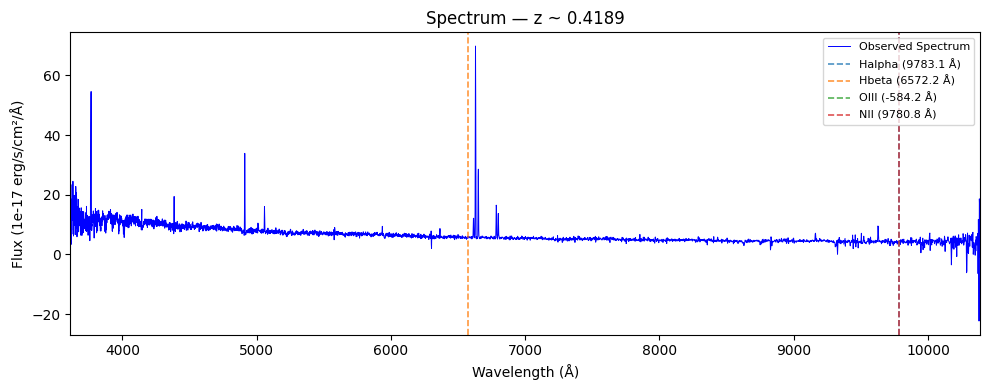

In [ ]:
# 1) Spectrum + fitted line centers
plt.figure(figsize=(10,4))
plt.plot(wave, flux, lw=0.7, color="blue", label="Observed Spectrum")

# Assign unique colors manually
colors = {
    "Hα": "red",
    "Hβ": "yellow",
    "[OIII]5007": "green",
    "[NII]6583": "orange",
    "[SII]6717": "purple",
    "[SII]6731": "brown",
}

for i, (name, lam0) in enumerate(REST.items()):
    mu = lines[name]["mu"]
    if np.isfinite(mu):
        # fallback: cycle through tab10 if not in dict
        c = colors.get(name, plt.cm.tab10(i % 10))
        plt.axvline(mu, ls='--', lw=1.2, alpha=0.8, color=c,
                    label=f"{name} ({mu:.1f} Å)")

plt.xlim(wave.min(), wave.max())
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (1e-17 erg/s/cm²/Å)")
plt.title(f"Spectrum — z ~ {z_final:.4f}" if np.isfinite(z_final) else "Spectrum")
plt.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()




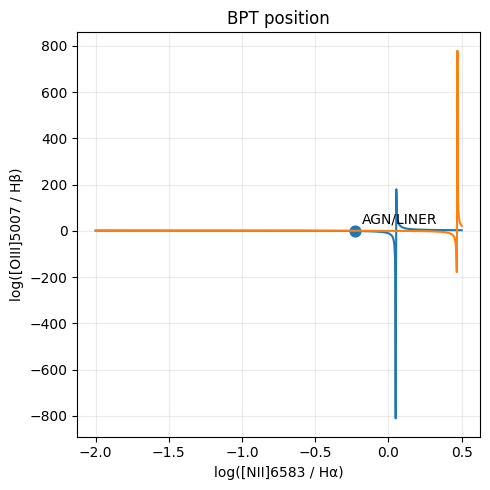

g-r: nan    Mr: nan


In [ ]:
# 2) BPT (single point + demarcations)
def kewley(x):  return 1.19 + 0.61/(x - 0.47)
def kauffmann(x): return 1.3 + 0.61/(x - 0.05)
xs = np.linspace(-2.0, 0.5, 600)
plt.figure(figsize=(5,5))
plt.plot(xs, kauffmann(xs))
plt.plot(xs, kewley(xs))
if np.isfinite(logN2Ha) and np.isfinite(logO3Hb):
    plt.scatter([logN2Ha], [logO3Hb], s=60)
    plt.annotate(bpt_class, (logN2Ha, logO3Hb), xytext=(5,5), textcoords='offset points')
plt.xlabel("log([NII]6583 / Hα)"); plt.ylabel("log([OIII]5007 / Hβ)")
plt.title("BPT position")
plt.grid(alpha=0.25); plt.tight_layout()
plt.show()
print("g-r:", g_minus_r, "   Mr:", Mr)

# 3) Color–Magnitude (single point)
if np.isfinite(g_minus_r) and np.isfinite(Mr):
    plt.figure(figsize=(5,5))
    plt.scatter([g_minus_r], [Mr], s=60)
    plt.gca().invert_yaxis()
    plt.xlabel("g − r"); plt.ylabel("M_r")
    plt.title("CMD (single galaxy)")
    plt.grid(alpha=0.25); plt.tight_layout()

plt.show()



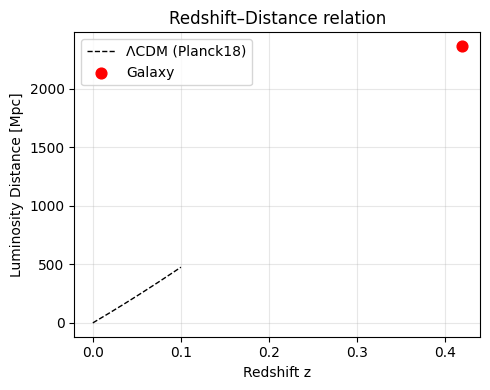

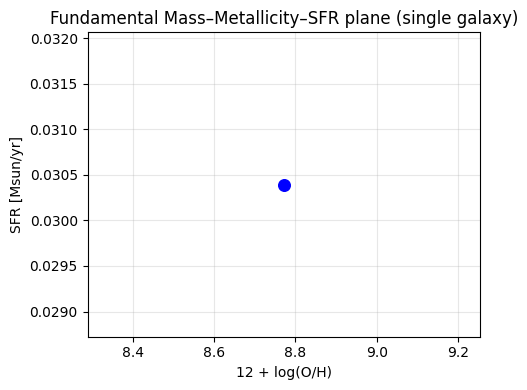

In [ ]:

# 4) Redshift–Distance Check

if np.isfinite(z_final) and np.isfinite(DL):
    plt.figure(figsize=(5,4))
    # A single point,
    zs = np.linspace(0, 0.1, 200)
    DLs = cosmo.luminosity_distance(zs).to(u.Mpc).value
    plt.plot(zs, DLs, 'k--', lw=1, label="ΛCDM (Planck18)")
    plt.scatter([z_final], [DL/1e6], s=60, c="red", label="Galaxy")
    plt.xlabel("Redshift z"); plt.ylabel("Luminosity Distance [Mpc]")
    plt.title("Redshift–Distance relation")
    plt.legend(); plt.grid(alpha=0.3)
    plt.tight_layout()


# 5) SFR vs Metallicity

if np.isfinite(SFR) and np.isfinite(Metallicity):
    plt.figure(figsize=(5,4))
    plt.scatter([Metallicity], [SFR], s=70, c="blue")
    plt.xlabel("12 + log(O/H)"); plt.ylabel("SFR [Msun/yr]")
    plt.title("Fundamental Mass–Metallicity–SFR plane (single galaxy)")
    plt.grid(alpha=0.3)
    plt.tight_layout()



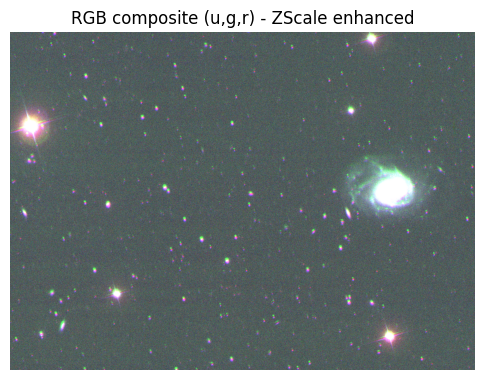

In [ ]:

# 6) RGB Image from ugr frames

from astropy.visualization import ZScaleInterval
from astropy.visualization import make_lupton_rgb
import numpy as np
import matplotlib.pyplot as plt

if all(os.path.exists(IMG_PATHS[b]) for b in ['r','g','i']):
    imgs = {}
    for b in ['r','g','i']:
        with fits.open(IMG_PATHS[b]) as hdul:
            imgs[b] = hdul[0].data.astype(float)

    # ZScale normalization for each band
    interval = ZScaleInterval()
    u_min, u_max = interval.get_limits(imgs['r'])
    g_min, g_max = interval.get_limits(imgs['g'])
    r_min, r_max = interval.get_limits(imgs['i'])

    u_scaled = np.clip((imgs['r'] - u_min) / (u_max - u_min), 0, 1)
    g_scaled = np.clip((imgs['g'] - g_min) / (g_max - g_min), 0, 1)
    r_scaled = np.clip((imgs['i'] - r_min) / (r_max - r_min), 0, 1)

    # Stack into RGB (note: r,g,u order -> looks more natural)
    rgb = np.dstack([r_scaled, g_scaled, u_scaled])
    #rgb = make_lupton_rgb(r_scaled, g_scaled, u_scaled)
    plt.figure(figsize=(6,6))
    plt.imshow(rgb, origin="lower")
    plt.title("RGB composite (u,g,r) - ZScale enhanced")
    plt.axis("off")
else:
    print("No FITS frames found for RGB visualization.")


Deblending:   0%|          | 0/119 [00:00<?, ?it/s]

Saved source list: Galaxies Spectrography and Analysis 2\data\galaxy_2\detected_sources.csv
    ID            x          y      RA_deg    Dec_deg  area_px  elongation  \
0    1   732.189520   0.609727  175.211547  47.576783     25.0    2.295374   
1    2  1267.017760   4.123781  175.201187  47.635216     35.0    1.073675   
2    3  1228.571690   8.408579  175.202667  47.631078     50.0    1.062789   
3    4   889.538364  22.278492  175.211842  47.594259     54.0    1.137296   
4    5  1318.760828  26.194176  175.203704  47.641169     52.0    1.195620   
5    6   975.518216  43.475453  175.213518  47.603937    132.0    1.109429   
6    7  1812.598821  44.910545  175.196629  47.695337     64.0    1.018122   
7    8  1141.942775  68.687265  175.214202  47.622453     28.0    1.547425   
8    9  1623.542520  73.630419  175.205157  47.675095     68.0    1.734070   
9   10   619.238516  76.389247  175.226113  47.565496     46.0    1.234063   
10  11  1534.909798  91.042050  175.209793  47.665

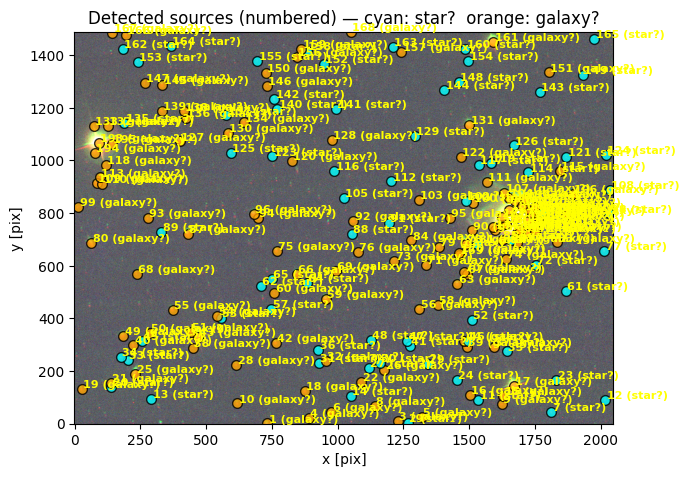

In [ ]:

# 7) Source detection + labeling (with optional names)

from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from photutils.segmentation import detect_threshold, SourceFinder, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground
from astropy.convolution import Gaussian2DKernel
from astropy.visualization import ImageNormalize, ZScaleInterval
import numpy as np

# ---- settings you can tweak ----
DETECT_BAND = 'r'        # band to detect sources in (good S/N)
NSIGMA_DET  = 3.0        # detection threshold in sigma
NPIX_MIN    = 20         # minimum npixels for a detection (rejects tiny noise blips)
FWHM_GUESS  = 3.0        # pixels; used to build a smoothing kernel
DO_CROSSMATCH = False    
SEARCH_RADIUS_ARCSEC = 2.0
# --------------------------------

def load_band_image(path):
    with fits.open(path) as hdul:
        data = hdul[0].data.astype(float)
        hdr  = hdul[0].header
    return data, hdr

def build_display_image(imgs_dict):
    """Return (rgb_array or grayscale, is_rgb_bool). Uses existing RGB (u,g,r) if available."""
    if all(k in imgs_dict for k in ['u','g','r']):
        # Build an RGB using ZScale for each band (same approach you liked)
        interval = ZScaleInterval()
        u = imgs_dict['u']; g = imgs_dict['g']; r = imgs_dict['r']
        u_min,u_max = interval.get_limits(u); u_scaled = np.clip((u-u_min)/(u_max-u_min), 0, 1)
        g_min,g_max = interval.get_limits(g); g_scaled = np.clip((g-g_min)/(g_max-g_min), 0, 1)
        r_min,r_max = interval.get_limits(r); r_scaled = np.clip((r-r_min)/(r_max-r_min), 0, 1)
        rgb = np.dstack([r_scaled, g_scaled, u_scaled])
        return rgb, True
    else:
        # fallback to DETECT_BAND as grayscale
        norm = ImageNormalize(imgs_dict[DETECT_BAND], interval=ZScaleInterval())
        gray = norm(imgs_dict[DETECT_BAND])
        return gray, False

def quick_star_galaxy_flag(cat, fwhm_guess_pix=FWHM_GUESS):
    """
    Very rough classifier:
      - compute 'circularized' sigma = sqrt(a*b)
      - PSF-like if ~ fwhm_guess/2.355, extended otherwise
      - also use elongation (a/b) as hint
    Returns array of strings: 'star?' or 'galaxy?'
    """
    a = cat.semimajor_sigma.value
    b = cat.semiminor_sigma.value
    elong = np.where(b>0, a/b, np.nan)
    sigma_circ = np.sqrt(a*b)
    psf_sigma = fwhm_guess_pix/2.355
    size_ratio = sigma_circ/psf_sigma
    cls = np.where((size_ratio<1.3) & (elong<1.3), 'star?', 'galaxy?')
    return cls, elong, size_ratio

# --- load detection band and WCS ---
if os.path.exists(IMG_PATHS.get(DETECT_BAND,'')):
    det_img, det_hdr = load_band_image(IMG_PATHS[DETECT_BAND])
    wcs = WCS(det_hdr)
else:
    print(f"No {DETECT_BAND}-band FITS found; skipping source detection.")
    det_img, det_hdr, wcs = None, None, None

# --- run detection ---
if det_img is not None:
    # robust background estimate (2D) then threshold
    bkg = Background2D(det_img, box_size=64, filter_size=3, bkg_estimator=MedianBackground())
    img_sub = det_img - bkg.background

    # smoothing helps split faint extended from noise
    kernel = Gaussian2DKernel(FWHM_GUESS/2.355, x_size=5, y_size=5)
    kernel.normalize()

    finder = SourceFinder(npixels=NPIX_MIN, connectivity=8, progress_bar=False)
    segm = finder(img_sub, thresh)

    # gentle deblend to separate close companions
    if segm is not None:
        segm_deblend = deblend_sources(img_sub, segm, npixels=NPIX_MIN, nlevels=32, contrast=0.001)

    else:
        print("No detections at chosen threshold.")
    
    if (segm is not None) and (segm.nlabels>0):
        cat = SourceCatalog(img_sub, segm, wcs=wcs)
        # measurements
        x  = cat.xcentroid
        y  = cat.ycentroid
        ra = cat.sky_centroid.icrs.ra.deg
        dec= cat.sky_centroid.icrs.dec.deg
        area = cat.area
        flux = cat.segment_flux if hasattr(cat, "segment_flux") else cat.area.value
        cls, elong, sizer = quick_star_galaxy_flag(cat)

        # for plotting, build the display image (RGB preferred)
        imgs_for_display = {}
        for b in ['u','g','r']:
            if os.path.exists(IMG_PATHS[b]):
                with fits.open(IMG_PATHS[b]) as hdul:
                    imgs_for_display[b] = hdul[0].data.astype(float)
        if DETECT_BAND not in imgs_for_display and os.path.exists(IMG_PATHS[DETECT_BAND]):
            with fits.open(IMG_PATHS[DETECT_BAND]) as hdul:
                imgs_for_display[DETECT_BAND] = hdul[0].data.astype(float)

        disp, is_rgb = build_display_image(imgs_for_display)

        plt.figure(figsize=(7,7))
        if is_rgb:
            plt.imshow(disp, origin='lower')
        else:
            plt.imshow(disp, cmap='gray', origin='lower')

        # overlay apertures/labels
        for i in range(len(x)):
            # color by class guess
            c = 'cyan' if cls[i]=='star?' else 'orange'
            plt.plot(x[i], y[i], marker='o', ms=7, mec='k', mfc=c, alpha=0.8)
            label = f"{i+1} ({cls[i]})"
            plt.text(x[i]+5, y[i]+5, label, color='yellow', fontsize=8, weight='bold')

        plt.title("Detected sources (numbered) — cyan: star?  orange: galaxy?")
        plt.xlabel("x [pix]"); plt.ylabel("y [pix]")
        plt.tight_layout()

        # print a small table to console (and optionally save)
        import pandas as pd
        src_tbl = pd.DataFrame({
            "ID": np.arange(1, len(x)+1),
            "x": x, "y": y, "RA_deg": ra, "Dec_deg": dec,
            "area_px": area, "elongation": elong, "size_ratio": sizer,
            "class_guess": cls
        })
        out_csv = os.path.join(GALAXY_DIR, "detected_sources.csv")
        src_tbl.to_csv(out_csv, index=False)
        print(f"Saved source list: {out_csv}")
        print(src_tbl.head(12))

        # ---------- OPTIONAL: cross-match to a catalog (Gaia or SDSS) ----------
        if DO_CROSSMATCH:
            try:
                from astroquery.vizier import Vizier
                from astropy.coordinates import SkyCoord
                import astropy.units as u
                Vizier.ROW_LIMIT = 1
                names = []
                for j in range(len(src_tbl)):
                    c = SkyCoord(src_tbl.loc[j,'RA_deg']*u.deg, src_tbl.loc[j,'Dec_deg']*u.deg)
                    # example: Gaia DR3
                    res = Vizier.query_region(c, radius=SEARCH_RADIUS_ARCSEC*u.arcsec,
                                              catalog="I/355/gaiadr3")
                    if len(res)>0 and len(res[0])>0:
                        # build a simple name (or pull 'Source' column if present)
                        names.append(f"Gaia DR3 {res[0][0]['Source']}")
                    else:
                        names.append("")
                src_tbl['catalog_name'] = names
                xcsv = os.path.join(GALAXY_DIR, "detected_sources_xmatched.csv")
                src_tbl.to_csv(xcsv, index=False)
                print(f"Saved cross-matched table: {xcsv}")
            except Exception as e:
                print(f"Cross-match skipped/failed: {e}")
    else:
        print("No sources detected.")
